In [3]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import stdev
from statistics import mean
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
# Defining Virus tramission temperarture range(in Fahrenheit)
a=60
b=95

In [6]:
# For feature transformation of average summer temperature
avg= 23.9   # In degree celcius, and obtained from Fig8 in the "paper". 
sigma= 1.5  #23.9+2*sigma=27. It will not change with change in temp from Celcius to Kelvin.

In [7]:
# Converting Fahrenheit to Kelvin
a=(a-32)*5/9 + 273
b=(b-32)*5/9 + 273
# Converting Celciusto Kelvin
avg+=273

In [8]:
# Variable for importing all the NARR data
# variables= ["air.2m", "air.sfc", "apcp", "rhum.2m"]
variables= ["air.2m", "apcp", "rhum.2m"]    #air.2m is being used for CDD calculation

In [9]:
months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
years=range(1999, 2016)

In [315]:
socio_regions={"WA":1, "OR":1, "CA":1, "MT":2, "ID":2, "WY":2, "NV":2, "UT":2, "CO":2, "AZ":2, "NM":2,"ND":3, "SD":3, "MN":3, "NE":3, "IA":3,"KS":3, "MO":3, "OK":4 , "TX":4, "AR":4, "LA":4, "WI":5, "MI":5, "IL":5, "IN":5, "OH":5, "KY":6, "TN":6, "AL":6, "MS":6, "WV":7, "VA":7, "NC":7, "SC":7, "DC":7, "MD":7, "DE":7, "GA":7, "FL":7, "PA":8, "NJ":8, "NY":8, "MA":9, "CT":9, "NH":9, "VT":9, "ME":9, "RI":9}
socio_key={1:"Pacific", 2:"Mountain", 3:"West North Central", 4: "West South Central", 5: "East North Central", 6: "East South Central", 7: "South Atlantic", 8: "Middle Atlantic", 9: "New England"}

In [320]:
weather_regions={"WA":1, "OR":1, "ID":1, "NV":2, "CA":2, "MT":3, "WY":3,"ND":3, "SD":3, "NE":3,"UT":4, "CO":4, "AZ":4, "NM":4, "MN":5,"WI":5, "MI":5, "IA":5,"KS":6, "OK":6 , "TX":6, "AR":6, "LA":6, "MS":6, "MO":7 , "IL":7, "IN":7, "OH":7, "KY":7, "TN":7, "WV":7, "AL":8, "VA":8, "NC":8, "SC":8, "GA":8, "FL":8, "DE":9, "DC":9, "MD":9, "PA":9, "NJ":9, "NY":9, "MA":9, "CT":9, "NH":9, "VT":9, "ME":9, "RI":9}
weather_key={1: "Northwest", 2: "West", 3: "West North Central", 4: "Southwest", 5: "East North Central", 6: "South", 7: "Central", 8: "Southeast", 9:"Northeast"}

In [12]:
# Importing WNV data
df= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/Arbovirus_risk_modeling_US/WNV_human_cases/WNV_NI_NNI_1999to2015_prevalence_incidence_final_20180530.csv", encoding='latin-1')
#Selecting Urban Counties
df=df[df["Select_County"]==1]
#Removing data for California due to data anomaly
df=df[df["STNAME"]!="California"]

df.rename(columns = {'GEOID10':'GEOID'}, inplace = True)

In [13]:
# Adding a column for incident year
incident_year=[years[-1] for i in range(len(df))]
for j in range(len(df)):
    for i in years:
        if(df.iloc[j]["NI_IR_" + str(i)]!=0):
            incident_year[j]=i
            break
df["Incident_year"]=incident_year

In [14]:
# Adding temp, precp, and humidity data
df_mod=df.copy()
for i in variables:
    for j in years:
        for k in range(len(months)):
            #Importing monthly Variable data
            data= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/narr_urban_county_data_masked/" + i +"_masked/"+ str(j) + "_" + months[k] + "_masked.csv")
            data=data[["GEOID", "mean"]]
            data.rename(columns = {'mean': i + '_' + str(j) + "_" + months[k]}, inplace = True)
            df_mod=df_mod.join(data.set_index('GEOID'), on='GEOID')

In [56]:
#Adding socioeconomic and weather regions classification column
sc=[]
we=[]
for i in range(len(df_mod)):
    sc.append(socio_regions[df_mod.iloc[i]["STUSPS"]])
    we.append(weather_regions[df_mod.iloc[i]["STUSPS"]])
df_mod["Socio_econ_class"]=sc 
df_mod["Weather_class"]=we

In [65]:
#df_mod=df_mod[:10]   # Just for simplicity

In [35]:
# For transforming temperature into normally distributed variable
def temp_transform(temp):
    ans= (1/(np.sqrt(2*np.pi)*sigma))*(np.exp(-((temp-avg)**2)/(2* (sigma)**2)))
    return ans

In [57]:
cdd=[]        #cumulative degree days  
cp=[]         #cumulative precipitation
# temp_avg=[]   #Average temperature within replication range (mean summer temp)
# prec_avg=[]   #Average precipitation within replication range
# hum_avg=[]    #Average humidity within replication range
# temp_sd=[]    #Temperature Std.dev. within replication range
# prec_sd=[]    #Precipitation Std.dev. within replication range
# hum_sd=[]     #Humidity Std.dev. within replication range
# temp_y_sd=[]  #Temperature yearly Std.dev. within replication range
# prec_y_sd=[]  #Precipitation yearly Std.dev. within replication range
# hum_y_sd=[]   #Humidity yearly Std.dev. within replication range
# temp_o_avg=[] #Average temperature outside replication range
# prec_o_avg=[] #Average precipitation outside replication range
# hum_o_avg=[]  #Average humidity outside replication range
ir=[]         #For storing IR of WNV
geoid=[]      #For storing GEOIDs
weather_class=[]  #For storing Weather region classification variable
socio_class=[]    #For storing socio-economic region classification variable


for i in range(len(df_mod)):

    inc_year= df_mod.iloc[i]["Incident_year"]  # 1st year of WNV incidence
    
    for j in range(inc_year+1, years[-1]+1):    # For all years after first incident year
        #Number of days in february
        feb=28
        #For leap year
        if(j%4==0):
            feb=29
        #Months with number of days
        days={"01":31, "02":feb, "03" :31, "04":30, "05":31, "06":30, "07":31, "08":31, "09":30, "10":31, "11":30, "12":31}        
        
        v_cdd=0
        v_cp=0
#         v_temp_avg=[]
#         v_prec_avg=[]
#         v_hum_avg=[]
#         v_temp_y_sd=[]
#         v_prec_y_sd=[]
#         v_hum_y_sd=[]
#         v_temp_o_avg=[]
#         v_prec_o_avg=[]
#         v_hum_o_avg=[]
        
        for k in months:
#             v_temp_y_sd.append(df_mod.iloc[i][variables[0] + "_" + str(j) + "_" + k])
#             v_prec_y_sd.append(df_mod.iloc[i][variables[1] + "_" + str(j) + "_" + k])
#             v_hum_y_sd.append(df_mod.iloc[i][variables[2] + "_" + str(j) + "_" + k])
            
            if((df_mod.iloc[i][variables[0] + "_" + str(j) + "_" + k]>=a) and (df_mod.iloc[i][variables[0] + "_" + str(j) + "_" + k]<=b)):
                v_cdd=v_cdd + days[k]
                v_cp=v_cp + df_mod.iloc[i][variables[1] + "_" + str(j) + "_" + k]
                
#                 v_temp_avg.append(df_mod.iloc[i][variables[0] + "_" + str(j) + "_" + k])
#                 v_prec_avg.append(df_mod.iloc[i][variables[1] + "_" + str(j) + "_" + k])
#                 v_hum_avg.append(df_mod.iloc[i][variables[2] + "_" + str(j) + "_" + k])
                
#             else:
#                 v_temp_o_avg.append(df_mod.iloc[i][variables[0] + "_" + str(j) + "_" + k])
#                 v_prec_o_avg.append(df_mod.iloc[i][variables[1] + "_" + str(j) + "_" + k])
#                 v_hum_o_avg.append(df_mod.iloc[i][variables[2] + "_" + str(j) + "_" + k])
                
        
        # Calculating and appending std. dev., mean and values of the variables.

#         temp_y_sd.append(np.std(np.array(v_temp_y_sd)))
#         prec_y_sd. append(np.std(np.array(v_prec_y_sd)))
#         hum_y_sd. append(np.std(np.array(v_hum_y_sd)))
      
        geoid.append(df_mod.iloc[i]["GEOID"])
        ir.append(df_mod.iloc[i]["NI_IR_" + str(j)])
        weather_class.append(df_mod.iloc[i]["Weather_class"])
        socio_class.append(df_mod.iloc[i]["Socio_econ_class"])
        
        cdd.append(v_cdd)
        cp.append(v_cp)
        
#         temp_avg.append(mean(np.array(v_temp_avg)))
#         prec_avg.append(mean(np.array(v_prec_avg)))
#         hum_avg.append(mean(np.array(v_hum_avg)))
        
#         temp_sd.append(stdev(np.array(v_temp_avg)))
#         prec_sd.append(stdev(np.array(v_prec_avg)))
#         hum_sd.append(stdev(np.array(v_hum_avg)))
        
#         temp_o_avg.append(mean(np.array(v_temp_o_avg)))
#         prec_o_avg.append(mean(np.array(v_prec_o_avg)))
#         hum_o_avg.append(mean(np.array(v_hum_o_avg)))

In [308]:
final=pd.DataFrame()
final["GEOID"]=geoid
final["IR"]=ir
final["CDD"]=cdd
final["CP"]=cp
final["We_cl"]=weather_class
final["So_cl"]=socio_class
# final["Temp_avg"]=temp_avg
# final["Prec_avg"]=prec_avg
# final["Hum_avg"]=hum_avg
# final["Temp_sd"]=temp_sd
# final["Prec_sd"]=prec_sd
# final["Hum_sd"]=hum_sd
# final["Temp_y_sd"]=temp_y_sd
# final["Prec_y_sd"]=prec_y_sd
# final["Hum_y_sd"]=hum_y_sd
# final["Temp_o_avg"]=temp_o_avg
# final["Prec_o_avg"]=prec_o_avg
# final["Hum_o_avg"]=hum_o_avg
#final=final[final["So_cl"]==10]

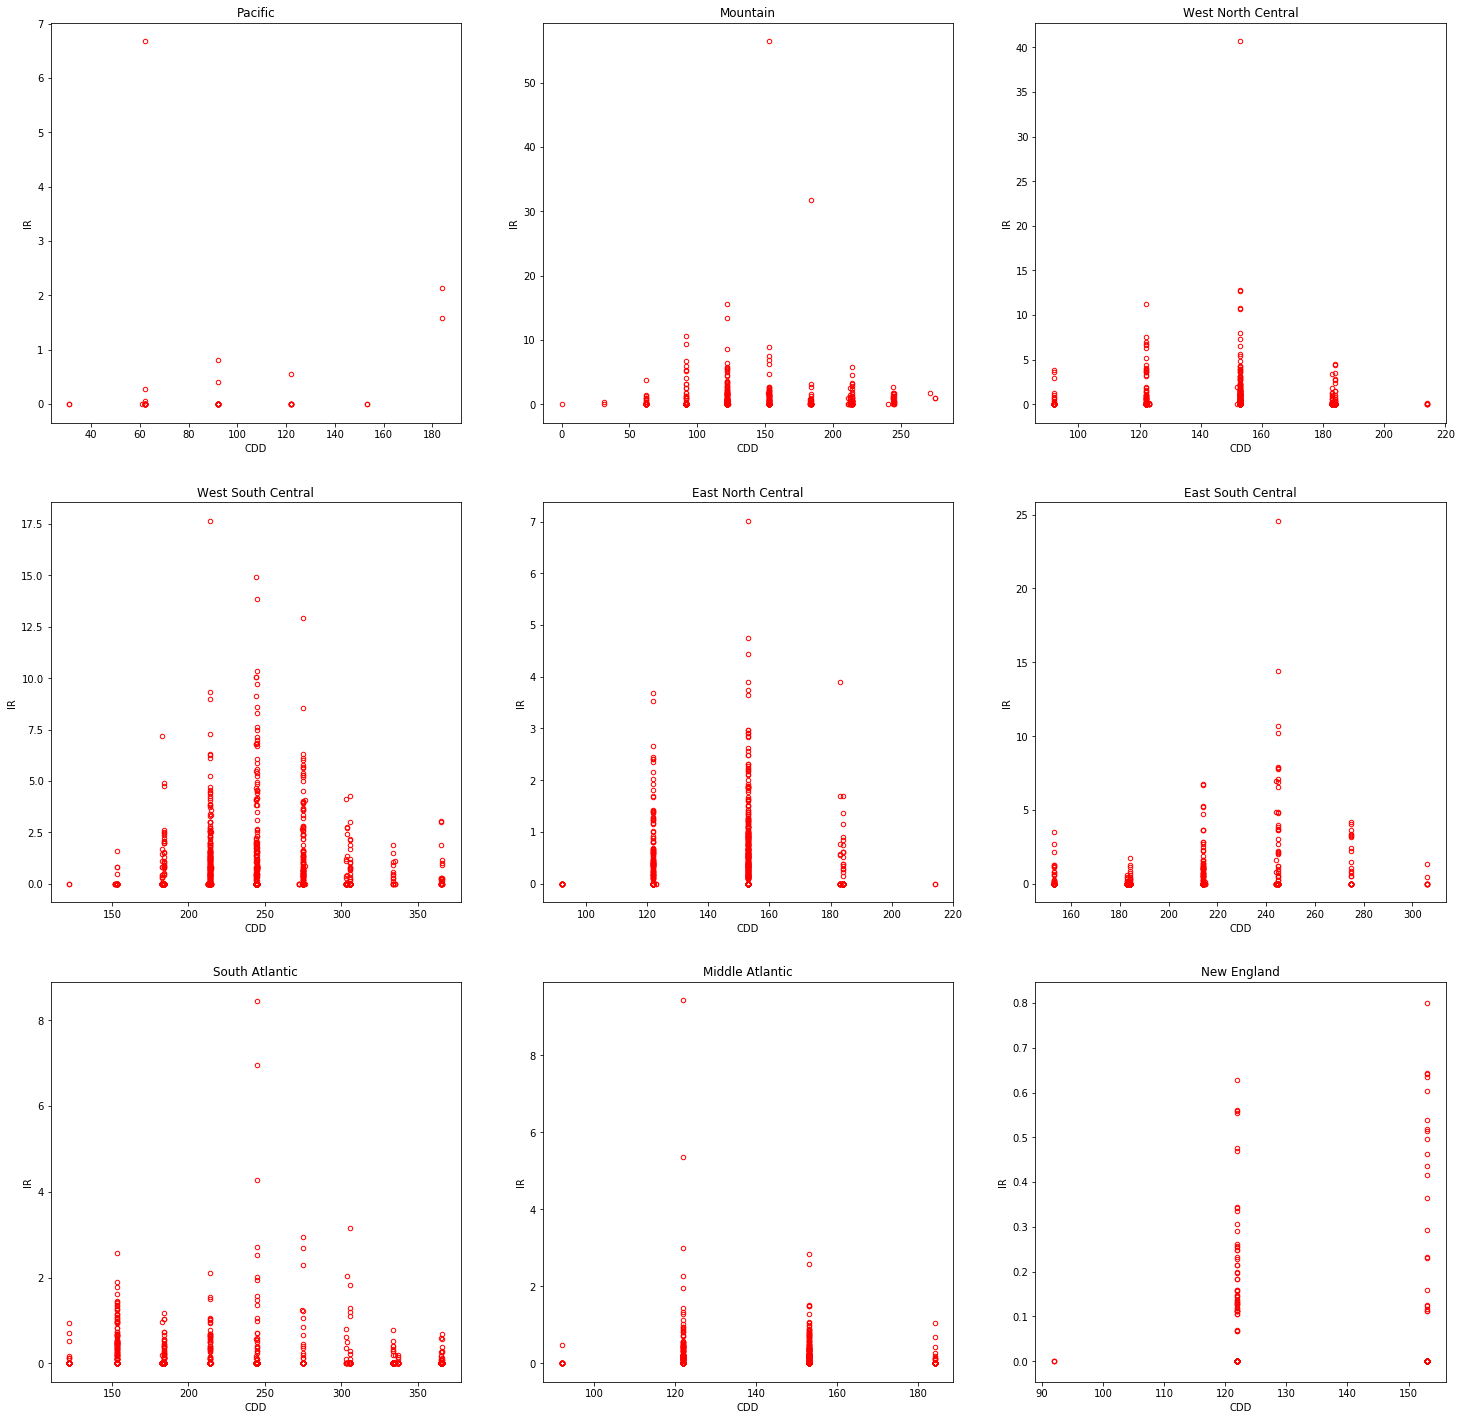

In [317]:
for i in set(socio_regions.values()):
    df_temp=pd.DataFrame()
    df_temp["CDD"]=final[final["So_cl"]==i]["CDD"]
    df_temp["IR"]=final[final["So_cl"]==i]["IR"]
    ax=plt.subplot(3,3,i)
    ax.set_title(socio_key[i])
    df_temp.plot(kind='scatter',x='CDD',y='IR', ax=ax, figsize=(25,25),color="None", edgecolors='red') 

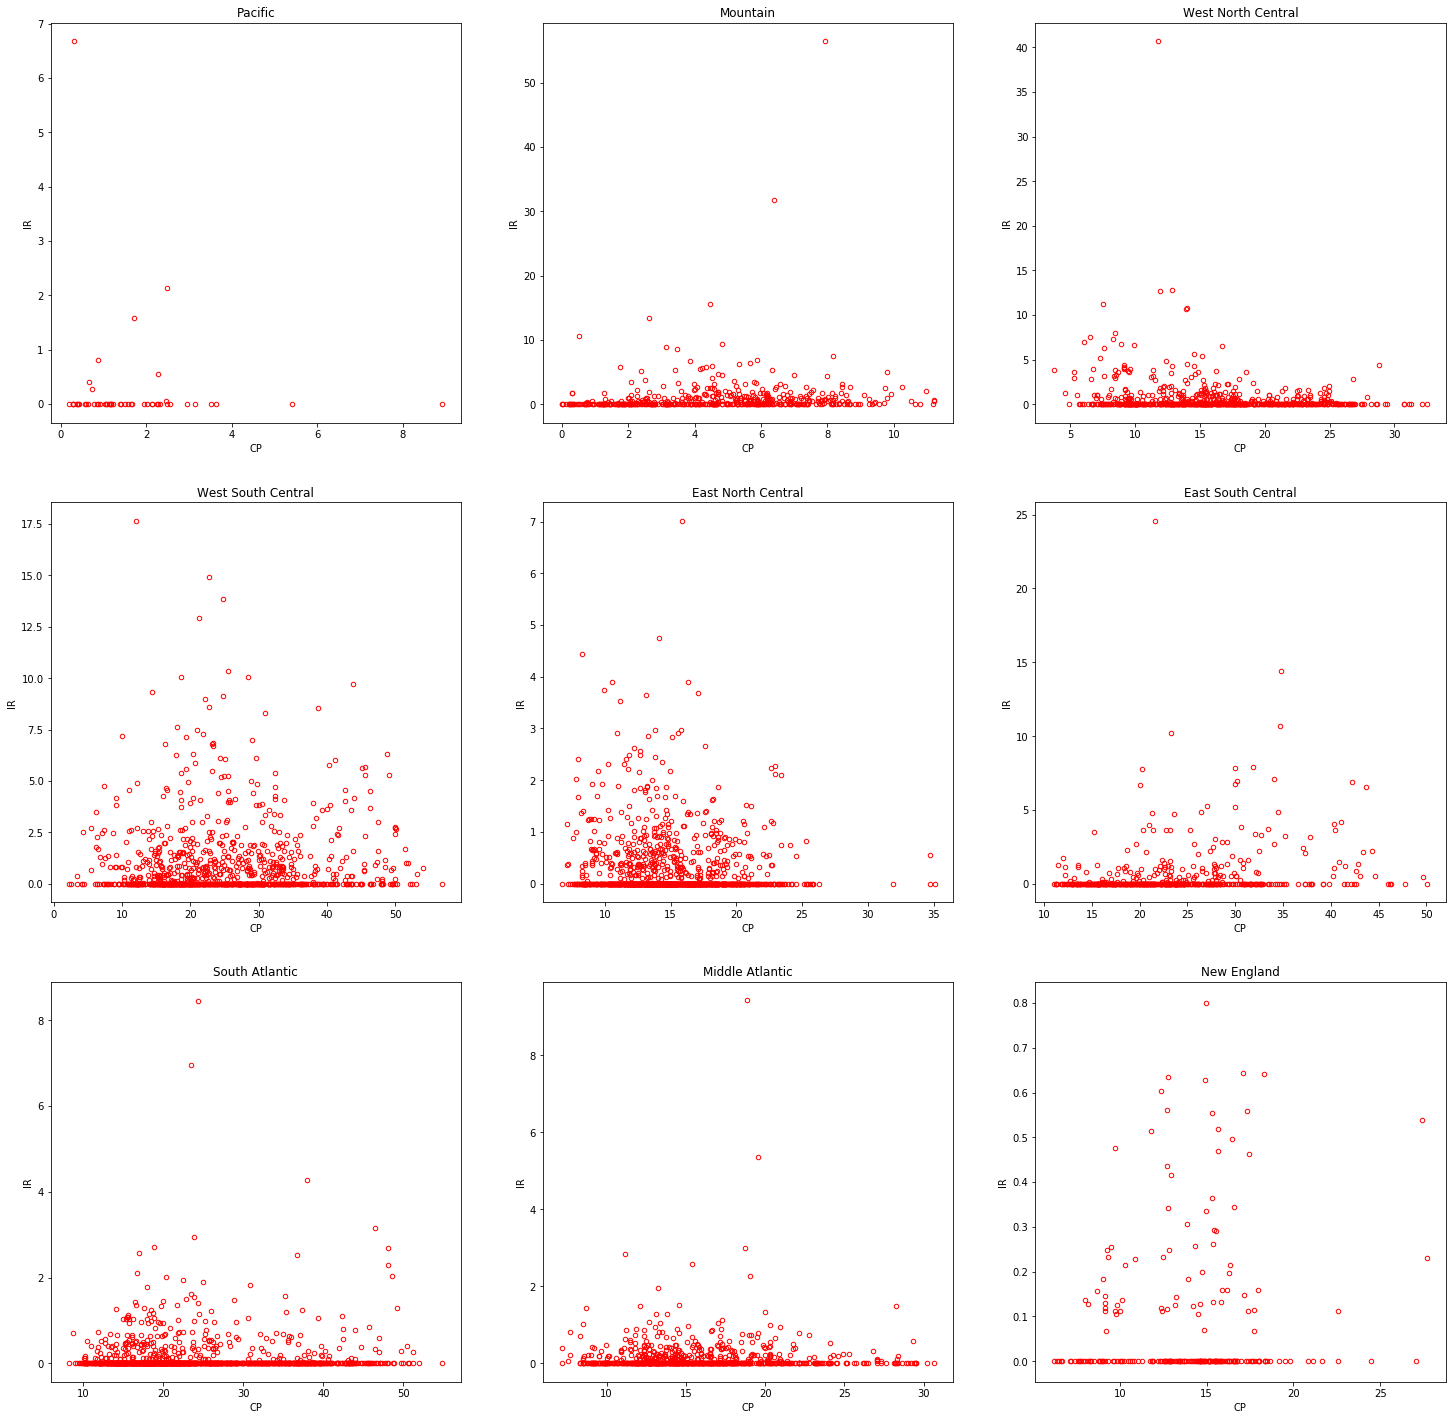

In [322]:
for i in set(socio_regions.values()):
    df_temp=pd.DataFrame()
    df_temp["CP"]=final[final["So_cl"]==i]["CP"]
    df_temp["IR"]=final[final["So_cl"]==i]["IR"]
    ax=plt.subplot(3,3,i)
    ax.set_title(socio_key[i])
    df_temp.plot(kind='scatter',x='CP',y='IR', ax=ax, figsize=(25,25),color="None", edgecolors='red') 

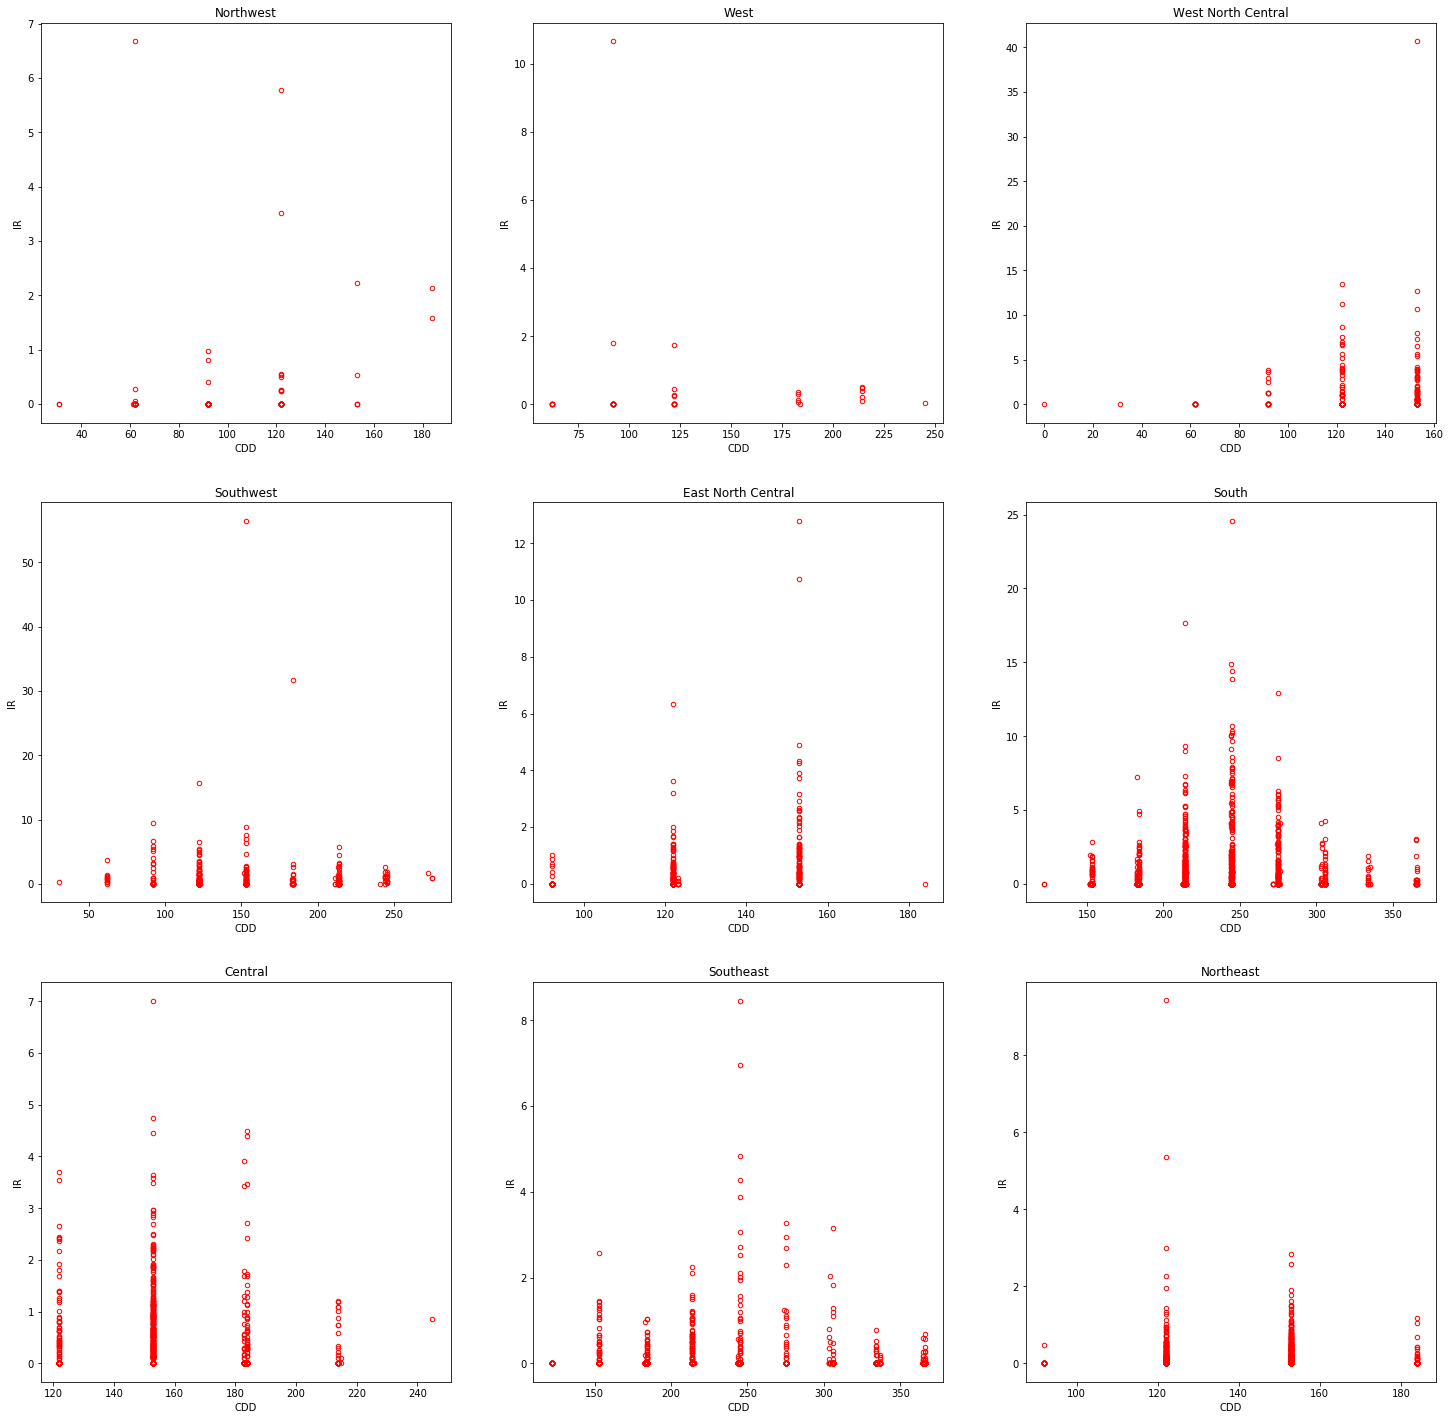

In [325]:
for i in set(weather_regions.values()):
    df_temp=pd.DataFrame()
    df_temp["CDD"]=final[final["We_cl"]==i]["CDD"]
    df_temp["IR"]=final[final["We_cl"]==i]["IR"]
    ax=plt.subplot(3,3,i)
    ax.set_title(weather_key[i])
    df_temp.plot(kind='scatter',x='CDD',y='IR', ax=ax, figsize=(25,25),color="None", edgecolors='red') 

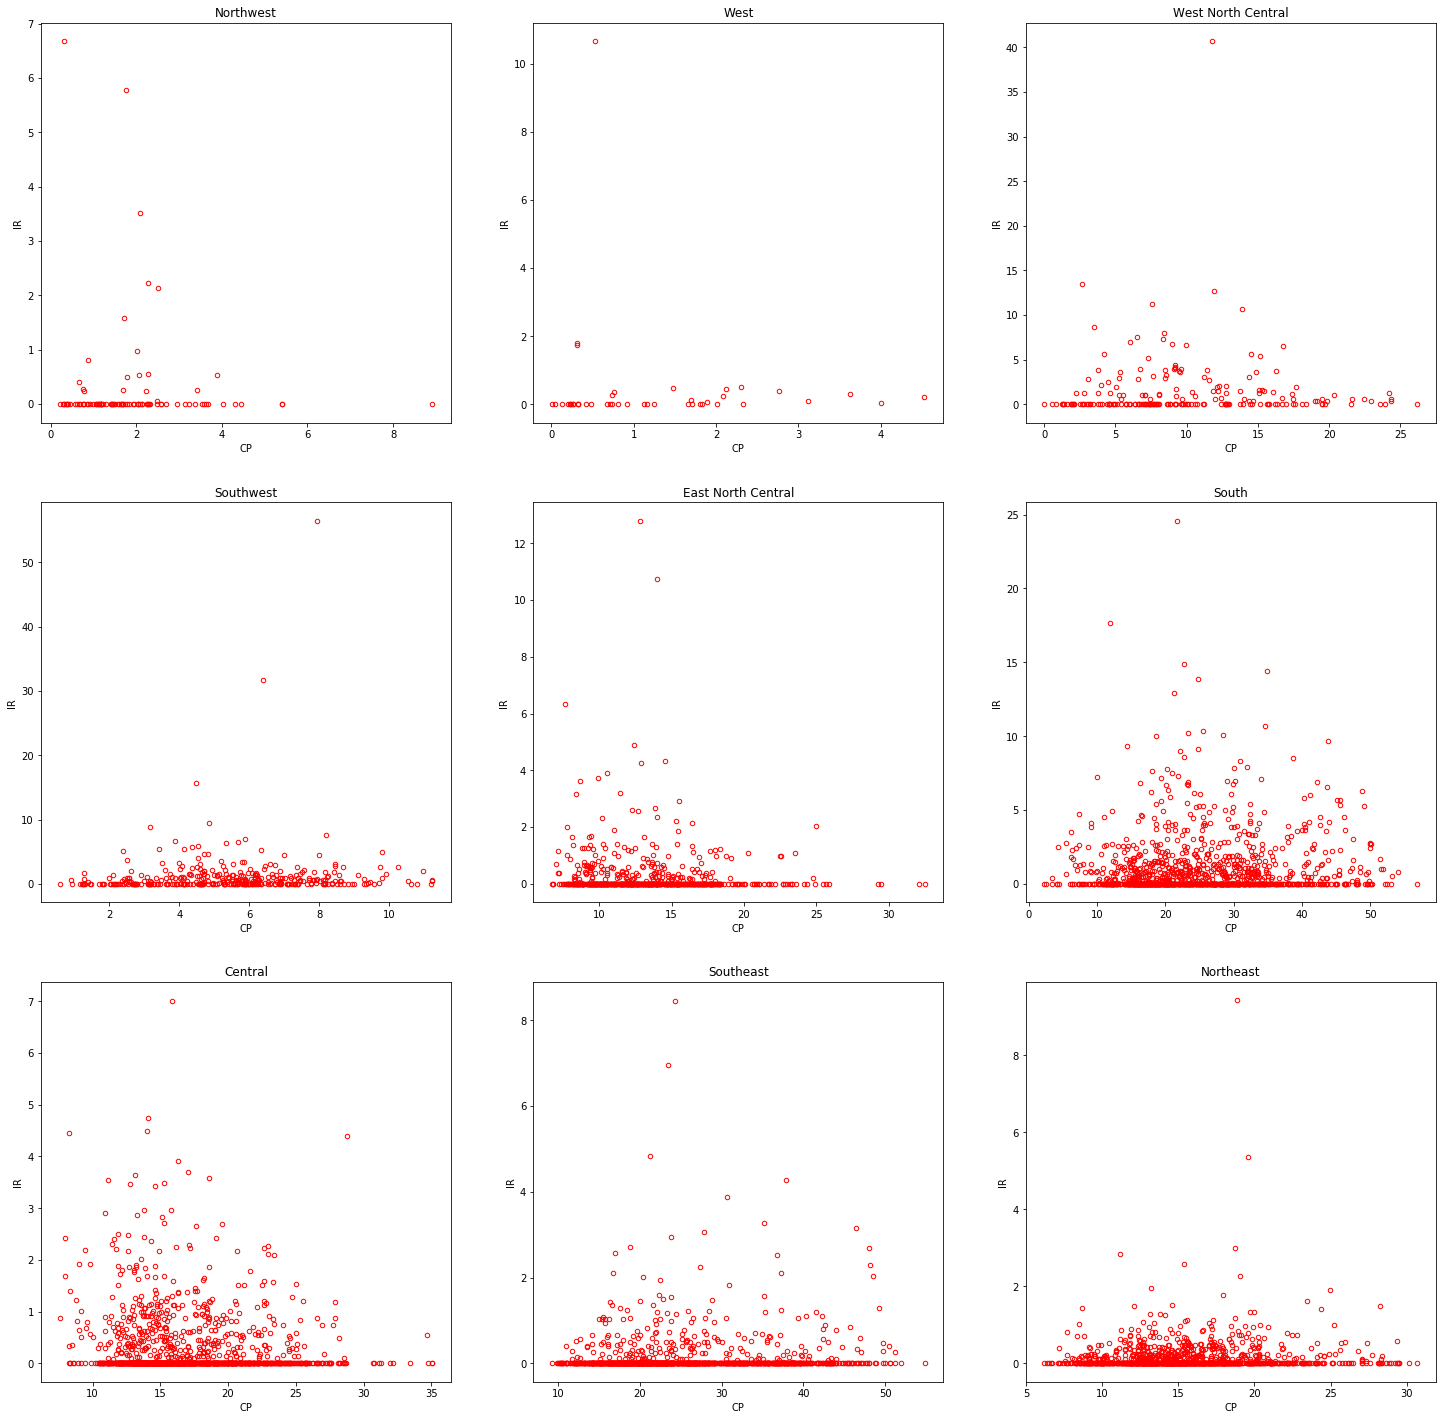

In [323]:
for i in set(weather_regions.values()):
    df_temp=pd.DataFrame()
    df_temp["CP"]=final[final["We_cl"]==i]["CP"]
    df_temp["IR"]=final[final["We_cl"]==i]["IR"]
    ax=plt.subplot(3,3,i)
    ax.set_title(weather_key[i])
    df_temp.plot(kind='scatter',x='CP',y='IR', ax=ax, figsize=(25,25),color="None", edgecolors='red') 

In [290]:
#Looking at correlation between variables (especially between IR and rest of the variables)
final.corr()

,GEOID,IR,CDD,CP,We_cl,So_cl
GEOID,1.000000,-0.023260,-0.194899,-0.205212,-0.045509,0.040507
IR,-0.023260,1.000000,0.060322,0.003981,-0.171647,-0.169858
CDD,-0.194899,0.060322,1.000000,0.745309,0.139321,0.060493
CP,-0.205212,0.003981,0.745309,1.000000,0.323446,0.240303
We_cl,-0.045509,-0.171647,0.139321,0.323446,1.000000,0.891681
So_cl,0.040507,-0.169858,0.060493,0.240303,0.891681,1.000000


In [291]:
#final=final[final["So_cl"]==1]

In [292]:
data=final[["IR", "CDD", "CP"]]

In [293]:
data=shuffle(data)

In [294]:
#Splitting dataset into testing and training set
train, test= train_test_split(data, test_size=0.20)

In [295]:
# Separating variabels and objective function values
X_train=train.iloc[:,1:]
Y_train=train.iloc[:,:1]
X_test=test.iloc[:,1:]
Y_test=test.iloc[:,:1]

In [296]:
#model=LinearRegression()

In [297]:
model=GradientBoostingRegressor()

In [298]:
model.fit(X_train.values, Y_train.values.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [299]:
# Calculating coefficient of determination on training set
model.score(X_train.values,Y_train.values)

0.4497027154246329

In [300]:
# Calculating coefficient of determination on testing set
model.score(X_test.values,Y_test.values )

-1.3026407111110432

In [301]:
#Predicting value on test dataset
Y_pred=model.predict(X_test.values)

In [302]:
#Calculating RMSE
np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

1.7496860115490145

In [303]:
result=pd.DataFrame()
result["Actual"]= list(Y_test.values)
result["Predicted"]= list(Y_pred)
result

,Actual,Predicted
0,[0.0],0.222392
1,[0.0],0.414541
2,[0.0],0.892710
3,[0.0],0.190457
4,[0.0],0.051753
...,...,...
1385,[0.0],0.272006
1386,[0.0],0.249009
1387,[0.0],0.220911
1388,[0.0],0.333533
